In [1]:
# this example requires that ENDFtk and ACEtk be installed as well
import ENDFtk
import ACEtk
import scion

import matplotlib.pyplot as plot
%matplotlib notebook

In [2]:
# the files we want to look at
endffile = 'resources/n-001_H_001-endf80.endf'
acefile = 'resources/n-001_H_001-endf80.ace'    # Lib80x at 293.6 K (1001.800c)

In [3]:
# a few functions we need (these will be integrated into scion when from_endf(...) becomes available)

# convert ENDF interpolation types into scion interpolation types
def convert_interpolants( interpolants ) :
    
    conversion = []
    for interpolant in interpolants :
        
        conversion.append( scion.interpolation.InterpolationType.LinearLinear 
                           if interpolant == 2 else scion.interpolation.InterpolationType.LogLog )
    
    return conversion

# convert ENDF boundaries (1-based index) into scion boundaries (0-based index)
def convert_boundaries( boundaries ) :
    
    return [ index - 1 for index in boundaries ]

In [4]:
# open the ENDF file and retrieve the capture cross section
tape = ENDFtk.tree.Tape.from_file( endffile )
endf_capture = tape.materials.front().file( 3 ).section( 102 ).parse()

print( 'number points: ', len( endf_capture.energies ) )
print( 'number interpolation regions: ', len( endf_capture.boundaries ) )
print( 'interpolation types: ', endf_capture.interpolants.to_list() )
print( 'boundaries indices: ', endf_capture.boundaries.to_list() )

number points:  153
number interpolation regions:  2
interpolation types:  [5, 2]
boundaries indices:  [33, 153]


In [5]:
# create an InterpolationTable from the ENDF data and linearise the data
capture = scion.math.InterpolationTable( x = endf_capture.energies.to_list(),
                                         y = endf_capture.cross_sections.to_list(),
                                         boundaries = convert_boundaries( endf_capture.boundaries ),
                                         interpolants = convert_interpolants( endf_capture.interpolants ) )

linearised = capture.linearise() # default tolerance of 0.1%

print( 'number points: ', len( linearised.x ) )

number points:  410


In [6]:
# open the ACE file and retrieve the capture cross section data
ace = ACEtk.ContinuousEnergyTable.from_file( acefile )

index = ace.reaction_number_block.index( 102 )
ace_capture = ace.cross_section_block.cross_section_data( index )

energy_index = ace_capture.energy_index

print( 'zaid: ', ace.header.zaid )
print( 'temperature: ', ace.header.temperature )
print( 'number points: ', len( ace_capture.cross_sections ) )
print( 'energy index: ', energy_index )

ace_energies = [ energy * 1e+6 for energy in ace.principal_cross_section_block.energies[ energy_index - 1: ] ]
ace_xs = ace_capture.cross_sections.to_list()

zaid:  1001.805nc
temperature:  8.6174e-12
number points:  631
energy index:  1


<IPython.core.display.Javascript object>


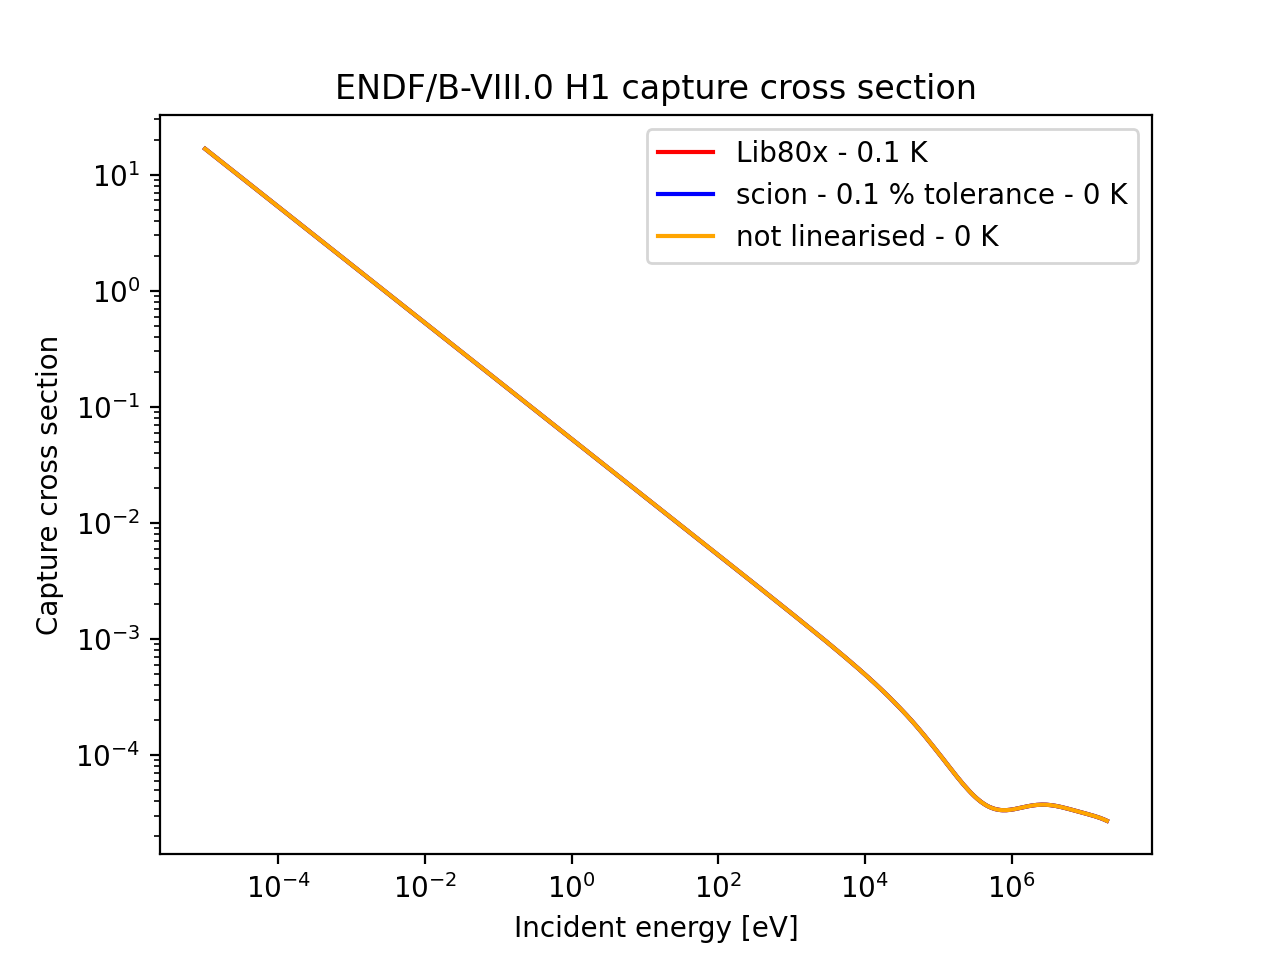

In [7]:
# plot the cross section data
plot.figure()
plot.plot( ace_energies, ace_xs, label = 'Lib80x - 0.1 K', color = 'red', linewidth = 1.5 )
plot.plot( linearised.x, linearised.y, label = 'scion - 0.1 % tolerance - 0 K', color = 'blue', linewidth = 1.5 )
plot.plot( endf_capture.energies, endf_capture.cross_sections, label = 'not linearised - 0 K', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Incident energy [eV]' )
plot.ylabel( 'Capture cross section' )
plot.title( 'ENDF/B-VIII.0 H1 capture cross section' )
plot.xscale( 'log' )
plot.yscale( 'log' )
plot.legend()
plot.show()